In [221]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from PIL import Image
import matplotlib.pyplot as plt

import torchvision.transforms as transforms
from torchvision.models import vgg19, VGG19_Weights

import copy
import requests
import os

In [222]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.set_default_device(device)

In [16]:
def download_image(url, type):
    response = requests.get(url)
    type_folder = 'style'
    if type == 1:
        type_folder = 'content'

    folder_path = f"./images/{type_folder}"

    files = [int(f.split(".")[0])
             for f in os.listdir(folder_path) if f.endswith(".jpg")]
    number = max(files, default=0) + 1

    with open(f"{folder_path}/{number:03}.jpg", "wb") as file:
        file.write(response.content)

In [316]:
download_image(
    'https://i.pinimg.com/control/564x/b5/a8/66/b5a8665da40cabdcd2b96490fee62bbf.jpg',
    0
)

In [317]:
style_path = r"./images/style/016.jpg"
content_path = r"./images/content/005.jpg"

In [318]:
imsize = 512 if torch.cuda.is_available() else 128

loader = transforms.Compose([
    transforms.Resize(imsize),
    transforms.ToTensor()])


def image_loader(image_name):
    image = Image.open(image_name)
    image = image.resize((500, 500))
    image = loader(image).unsqueeze(0)
    return image.to(device, torch.float)


style_img = image_loader(style_path)
content_img = image_loader(content_path)

assert style_img.size() == content_img.size()

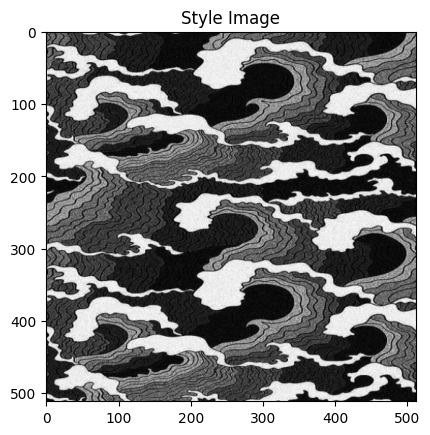

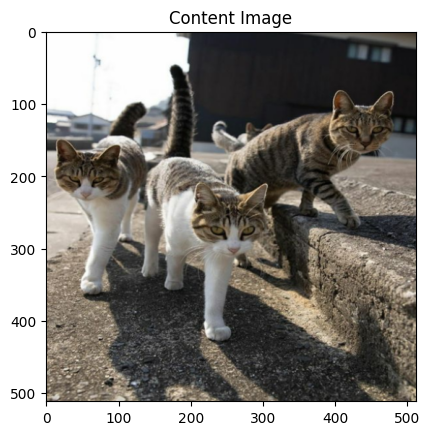

In [319]:
unloader = transforms.ToPILImage()

plt.ion()


def imshow(tensor, title=None):
    image = tensor.cpu().clone()
    image = image.squeeze(0)
    image = unloader(image)
    plt.imshow(image)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)


plt.figure()
imshow(style_img, title='Style Image')

plt.figure()
imshow(content_img, title='Content Image')

$\|F_{XL} - F_{CL}\|^2$

In [320]:
class ContentLoss(nn.Module):

    def __init__(self, target,):
        super(ContentLoss, self).__init__()
        self.target = target.detach()

    def forward(self, input):
        self.loss = F.mse_loss(input, self.target)
        return input

$g_{ij}=v_i^{T}v_j $

In [321]:
def gram_matrix(input):
    a, b, c, d = input.size()
    features = input.view(a * b, c * d)

    G = torch.mm(features, features.t())
    return G.div(a * b * c * d)

In [322]:
class StyleLoss(nn.Module):

    def __init__(self, target_feature):
        super(StyleLoss, self).__init__()
        self.target = gram_matrix(target_feature).detach()

    def forward(self, input):
        G = gram_matrix(input)
        self.loss = F.mse_loss(G, self.target)
        return input

In [323]:
cnn = vgg19(weights=VGG19_Weights.DEFAULT).features.eval()

In [324]:
cnn_normalization_mean = torch.tensor([0.485, 0.456, 0.406])
cnn_normalization_std = torch.tensor([0.229, 0.224, 0.225])


class Normalization(nn.Module):
    def __init__(self, mean, std):
        super(Normalization, self).__init__()

        self.mean = torch.tensor(mean).view(-1, 1, 1)
        self.std = torch.tensor(std).view(-1, 1, 1)

    def forward(self, img):
        # normalize ``img``
        return (img - self.mean) / self.std

In [325]:
content_layers_default = ['conv_4']
style_layers_default = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5']


def get_style_model_and_losses(cnn, normalization_mean, normalization_std,
                               style_img, content_img,
                               content_layers=content_layers_default,
                               style_layers=style_layers_default):
    # normalization module
    normalization = Normalization(normalization_mean, normalization_std)

    content_losses = []
    style_losses = []

    model = nn.Sequential(normalization)

    i = 0
    for layer in cnn.children():
        if isinstance(layer, nn.Conv2d):
            i += 1
            name = 'conv_{}'.format(i)
        elif isinstance(layer, nn.ReLU):
            name = 'relu_{}'.format(i)
            layer = nn.ReLU(inplace=False)
        elif isinstance(layer, nn.MaxPool2d):
            name = 'pool_{}'.format(i)
        elif isinstance(layer, nn.BatchNorm2d):
            name = 'bn_{}'.format(i)
        else:
            raise RuntimeError('Unrecognized layer: {}'.format(
                layer.__class__.__name__))

        model.add_module(name, layer)

        if name in content_layers:
            target = model(content_img).detach()
            content_loss = ContentLoss(target)
            model.add_module("content_loss_{}".format(i), content_loss)
            content_losses.append(content_loss)

        if name in style_layers:
            target_feature = model(style_img).detach()
            style_loss = StyleLoss(target_feature)
            model.add_module("style_loss_{}".format(i), style_loss)
            style_losses.append(style_loss)

    for i in range(len(model) - 1, -1, -1):
        if isinstance(model[i], ContentLoss) or isinstance(model[i], StyleLoss):
            break

    model = model[:(i + 1)]

    return model, style_losses, content_losses

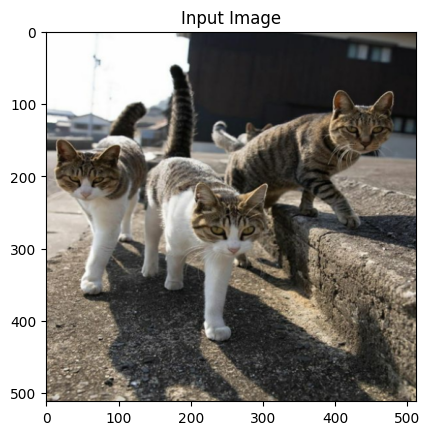

In [326]:
input_img = content_img.clone()

plt.figure()
imshow(input_img, title='Input Image')

In [327]:
def get_input_optimizer(input_img):
    optimizer = optim.LBFGS([input_img])
    return optimizer

In [328]:
def run_style_transfer(cnn, normalization_mean, normalization_std,
                       content_img, style_img, input_img, num_steps=300,
                       style_weight=1000000, content_weight=1):

    print('Building the style transfer model..')
    model, style_losses, content_losses = get_style_model_and_losses(cnn,
                                                                     normalization_mean, normalization_std, style_img, content_img)

    input_img.requires_grad_(True)
    model.eval()
    model.requires_grad_(False)

    optimizer = get_input_optimizer(input_img)

    print('Optimizing..')
    run = [0]
    while run[0] <= num_steps:

        def closure():
            with torch.no_grad():
                input_img.clamp_(0, 1)

            optimizer.zero_grad()
            model(input_img)
            style_score = 0
            content_score = 0

            for sl in style_losses:
                style_score += sl.loss
            for cl in content_losses:
                content_score += cl.loss

            style_score *= style_weight
            content_score *= content_weight

            loss = style_score + content_score
            loss.backward()

            run[0] += 1
            if run[0] % 50 == 0:
                print("run {}:".format(run))
                print('Style Loss : {:4f} Content Loss: {:4f}'.format(
                    style_score.item(), content_score.item()))
                print()

            return style_score + content_score

        optimizer.step(closure)

    with torch.no_grad():
        input_img.clamp_(0, 1)

    return input_img

In [329]:
output = run_style_transfer(cnn, cnn_normalization_mean, cnn_normalization_std,
                            content_img, style_img, input_img)

Building the style transfer model..
Optimizing..
run [50]:
Style Loss : 269.679199 Content Loss: 21.748859

run [100]:
Style Loss : 64.429581 Content Loss: 23.721779

run [150]:
Style Loss : 25.952766 Content Loss: 24.261169

run [200]:
Style Loss : 13.330684 Content Loss: 24.021349

run [250]:
Style Loss : 8.122313 Content Loss: 23.294901

run [300]:
Style Loss : 5.689764 Content Loss: 22.509327



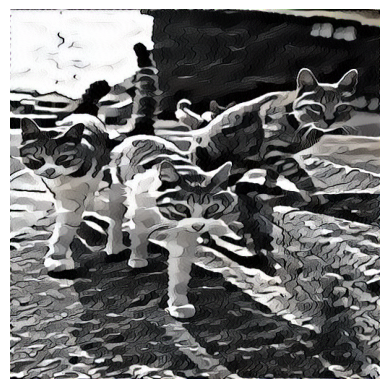

In [330]:
image_output = output.squeeze(0).permute(1, 2, 0).cpu().detach().numpy()

style_number = os.path.splitext(os.path.basename(style_path))[0]
content_number = os.path.splitext(os.path.basename(content_path))[0]
filename = f"s{style_number}_c{content_number}.png"

result_folder = './images/results/'
os.makedirs(result_folder, exist_ok=True)

plt.axis("off")
plt.imshow(image_output)
plt.savefig(f'{result_folder}{filename}', bbox_inches='tight', pad_inches=0)
plt.show()